#  Criação e modelagem de machine learning

#### Fazer importações

In [1]:
# Imports
import pandas as pd
from sklearn.utils import shuffle
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import unidecode
from string import punctuation
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix 
import seaborn as sn
import numpy as np 
import matplotlib.pyplot as plt
import pickle

# inicializa o nlp do spacy
nlp = spacy.load("pt_core_news_sm")

#### Leitura da base em JSON

In [2]:
# Ler arquivo Json - arquivo usando com orient=records
data = pd.read_json('definedcommentsdf.json')

# Cria um dataframe so para os valores das colunas toxico e comentario
comments_toxico = data.drop(['link','datahora'], axis=1)
comments_toxico.head()

,idcomentario,toxico,comentario,tipo
0,5e52b6f032766bbb6d01c5cc,False,Passando o pacote anti crime na camara e sena...,
1,5e52b83c32766bbb6d01d2c0,False,nossa ai fica dificil...antes sobia 20 reais ...,
2,5e52b83c32766bbb6d01d1e2,False,Até quando ele vai comparar tudo a um casamen...,
3,5e52b84f32766bbb6d01db26,False,99 nunca mais! Usei o 99 para pagar com cartã...,
4,5e52b84f32766bbb6d01d883,False,Já foi confirmado pela UFBA que é óleo venezu...,


## Aqui começa o tratamento da base

In [3]:
# Modifica valores false/true para 0,1
comments_toxico.loc[(comments_toxico.toxico == True),'toxico'] = 1
comments_toxico.loc[(comments_toxico.toxico == False),'toxico'] = 0

In [4]:
# DataFrame com toxicos e não toxicos
toxic_data = comments_toxico[comments_toxico.toxico == 1]
nontoxic_data = comments_toxico[comments_toxico.toxico == 0]

In [5]:
# Conta quantidade de cada classificacao
count_toxic = toxic_data.shape[0]
count_nontoxic = nontoxic_data.shape[0]

# Checa a quantidade de cada dataset e deixa 50%/50% de cada classificacao 
if count_nontoxic > count_toxic:
    nontoxic_data = nontoxic_data.sample(count_toxic, replace=True)
    
if count_toxic > count_nontoxic:
    toxic_data = toxic_data.sample(count_nontoxic, replace=True)
    
# Ignora Warnings de indexação
pd.options.mode.chained_assignment = None

# Cria contagem de idcomentarios iguais
nontoxic_data['amount_idcomentario']= nontoxic_data.idcomentario.map(nontoxic_data.idcomentario.value_counts())
toxic_data['amount_idcomentario']= toxic_data.idcomentario.map(toxic_data.idcomentario.value_counts())

# Criar listas de apoio
data_bigtoxic = [] 
data_bignontoxic = []
dataigual = []
for row in nontoxic_data.itertuples():
    for row1 in toxic_data.itertuples():
        if row1.idcomentario == row.idcomentario and row1.amount_idcomentario > row.amount_idcomentario:
            data_bigtoxic.append(row1)
        elif row1.idcomentario == row.idcomentario and row1.amount_idcomentario < row.amount_idcomentario:
            data_bignontoxic.append(row)
        elif row1.idcomentario == row.idcomentario and row1.amount_idcomentario == row.amount_idcomentario:
            dataigual.append(row1.idcomentario)
            

In [6]:
# Recria dataframe com samples de toxic e non toxic, resetando index 
mergedata = [nontoxic_data,toxic_data]
new_dataframe = pd.concat(mergedata)
new_dataframe.reset_index(drop=True, inplace=True)

In [7]:
# Remove comentarios que tem mesmo valor de toxico e nao toxico
data_framefinal = new_dataframe[~new_dataframe.idcomentario.isin(dataigual)]

In [8]:
# DataFrame axuliar para criar tokens do nlp do spacy
comentarios_df = data_framefinal.drop(['idcomentario','tipo','amount_idcomentario'], axis=1)
comentarios_df = comentarios_df.drop_duplicates(subset=['toxico', 'comentario'], keep='first') # remove itens duplicados
comentarios_df

,toxico,comentario
0,0,"Basta o imposto retornar ao povo em serviços,..."
1,0,"Prezado. No caso, usa-se o verbo no infinitivo."
2,0,A manchete deveria ser: 62% aprovam o governo...
3,0,"Guerra de bandidos, cade os grupos de dire..."
4,0,Quem tá mentindo?\nO Sr das armas ou o tiro n...
...,...,...
1566,1,Cara chato !
1567,1,Fala M não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão..."


## Aqui começa o pré-processamento

#### Cada pré-processamento foi separado em uma coluna do DataFrame de forma a treinar a ML individualmente para cada coluna do DataFrame

In [9]:
comentarios_df = comentarios_df.replace(r'\n', ' ', regex=True) 
comentarios_df

,toxico,comentario
0,0,"Basta o imposto retornar ao povo em serviços,..."
1,0,"Prezado. No caso, usa-se o verbo no infinitivo."
2,0,A manchete deveria ser: 62% aprovam o governo...
3,0,"Guerra de bandidos, cade os grupos de dire..."
4,0,Quem tá mentindo? O Sr das armas ou o tiro na...
...,...,...
1566,1,Cara chato !
1567,1,Fala M não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão..."


In [10]:
# Transforma todas as letras em minusculo
minusculo = []
for comentario in comentarios_df['comentario']:
    minusculo.append(comentario.lower())
    
comentarios_df['minusculo'] = minusculo

comentarios_df

,toxico,comentario,minusculo
0,0,"Basta o imposto retornar ao povo em serviços,...","basta o imposto retornar ao povo em serviços,..."
1,0,"Prezado. No caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo."
2,0,A manchete deveria ser: 62% aprovam o governo...,a manchete deveria ser: 62% aprovam o governo...
3,0,"Guerra de bandidos, cade os grupos de dire...","guerra de bandidos, cade os grupos de dire..."
4,0,Quem tá mentindo? O Sr das armas ou o tiro na...,quem tá mentindo? o sr das armas ou o tiro na...
...,...,...,...
1566,1,Cara chato !,cara chato !
1567,1,Fala M não vai...,fala m não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão..."


In [11]:
# Remove espaços em brancos das strings
comentarios_df['whitespacesnone'] = [comentario.strip() for comentario in comentarios_df['minusculo']] # unidecode

comentarios_df

,toxico,comentario,minusculo,whitespacesnone
0,0,"Basta o imposto retornar ao povo em serviços,...","basta o imposto retornar ao povo em serviços,...","basta o imposto retornar ao povo em serviços, ..."
1,0,"Prezado. No caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo."
2,0,A manchete deveria ser: 62% aprovam o governo...,a manchete deveria ser: 62% aprovam o governo...,a manchete deveria ser: 62% aprovam o governo ...
3,0,"Guerra de bandidos, cade os grupos de dire...","guerra de bandidos, cade os grupos de dire...","guerra de bandidos, cade os grupos de direi..."
4,0,Quem tá mentindo? O Sr das armas ou o tiro na...,quem tá mentindo? o sr das armas ou o tiro na...,quem tá mentindo? o sr das armas ou o tiro na ...
...,...,...,...,...
1566,1,Cara chato !,cara chato !,cara chato !
1567,1,Fala M não vai...,fala m não vai...,fala m não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão...","boisotrooper, a giobo de.ve mais de um biihão ..."


In [12]:
# Remove acentuação
comentarios_df['unidecode'] = [unidecode.unidecode(comentario) for comentario in comentarios_df['whitespacesnone']]

In [13]:
# Remove pontuação, stopwords, números soltos e gera os tokens SEM UNIDECODE
pontuacoes = list(punctuation)
novo_comentario = []
stop_word = list(nlp.Defaults.stop_words) 

for comentario in comentarios_df['whitespacesnone']:
    doc = nlp(comentario)
    c = ' '.join([token.text for token in doc if token.text not in pontuacoes and token.text not in stop_word and not token.text.isdigit()])
    novo_comentario.append(c)
    
comentarios_df['comentario_final_su'] = novo_comentario
comentarios_df

,toxico,comentario,minusculo,whitespacesnone,unidecode,comentario_final_su
0,0,"Basta o imposto retornar ao povo em serviços,...","basta o imposto retornar ao povo em serviços,...","basta o imposto retornar ao povo em serviços, ...","basta o imposto retornar ao povo em servicos, ...",basta o imposto retornar a o serviços saúde ed...
1,0,"Prezado. No caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo.",prezado caso usa-se o verbo infinitivo
2,0,A manchete deveria ser: 62% aprovam o governo...,a manchete deveria ser: 62% aprovam o governo...,a manchete deveria ser: 62% aprovam o governo ...,a manchete deveria ser: 62% aprovam o governo ...,a manchete deveria aprovam o governo ótimo reg...
3,0,"Guerra de bandidos, cade os grupos de dire...","guerra de bandidos, cade os grupos de dire...","guerra de bandidos, cade os grupos de direi...","guerra de bandidos, cade os grupos de direi...",guerra bandidos cade grupos direitos h...
4,0,Quem tá mentindo? O Sr das armas ou o tiro na...,quem tá mentindo? o sr das armas ou o tiro na...,quem tá mentindo? o sr das armas ou o tiro na ...,quem ta mentindo? o sr das armas ou o tiro na ...,tá mentindo o sr armas o tiro cabecinha verdad...
...,...,...,...,...,...,...
1566,1,Cara chato !,cara chato !,cara chato !,cara chato !,cara chato
1567,1,Fala M não vai...,fala m não vai...,fala m não vai...,fala m nao vai...,fala m ...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!!...,eu agora vou dormir!!! mas voces nao podem!!!...,vou dormir o plantão completo senão o dindin
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão...","boisotrooper, a giobo de.ve mais de um biihão ...","boisotrooper, a giobo de.ve mais de um biihao ...",boisotrooper a giobo de.ve biihão o flsc0 e co...


In [14]:
# Remove pontuação, stopwords, números soltos e gera os tokens COM UNIDECODE
pontuacoes = list(punctuation)
novo_comentario = []
stop_word = list(nlp.Defaults.stop_words) 

for comentario in comentarios_df['unidecode']:
    doc = nlp(comentario)
    c = ' '.join([token.text for token in doc if token.text not in pontuacoes and token.text not in stop_word and not token.text.isdigit()])
    novo_comentario.append(c)
    
comentarios_df['comentario_final_wu'] = novo_comentario
comentarios_df

,toxico,comentario,minusculo,whitespacesnone,unidecode,comentario_final_su,comentario_final_wu
0,0,"Basta o imposto retornar ao povo em serviços,...","basta o imposto retornar ao povo em serviços,...","basta o imposto retornar ao povo em serviços, ...","basta o imposto retornar ao povo em servicos, ...",basta o imposto retornar a o serviços saúde ed...,basta o imposto retornar a o servicos saude ed...
1,0,"Prezado. No caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo.","prezado. no caso, usa-se o verbo no infinitivo.",prezado caso usa-se o verbo infinitivo,prezado caso usa-se o verbo infinitivo
2,0,A manchete deveria ser: 62% aprovam o governo...,a manchete deveria ser: 62% aprovam o governo...,a manchete deveria ser: 62% aprovam o governo ...,a manchete deveria ser: 62% aprovam o governo ...,a manchete deveria aprovam o governo ótimo reg...,a manchete deveria aprovam o governo otimo reg...
3,0,"Guerra de bandidos, cade os grupos de dire...","guerra de bandidos, cade os grupos de dire...","guerra de bandidos, cade os grupos de direi...","guerra de bandidos, cade os grupos de direi...",guerra bandidos cade grupos direitos h...,guerra bandidos cade grupos direitos h...
4,0,Quem tá mentindo? O Sr das armas ou o tiro na...,quem tá mentindo? o sr das armas ou o tiro na...,quem tá mentindo? o sr das armas ou o tiro na ...,quem ta mentindo? o sr das armas ou o tiro na ...,tá mentindo o sr armas o tiro cabecinha verdad...,ta mentindo o sr armas o tiro cabecinha verdad...
...,...,...,...,...,...,...,...
1566,1,Cara chato !,cara chato !,cara chato !,cara chato !,cara chato,cara chato
1567,1,Fala M não vai...,fala m não vai...,fala m não vai...,fala m nao vai...,fala m ...,fala m nao ...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!!...,eu agora vou dormir!!! mas voces nao podem!!!...,vou dormir o plantão completo senão o dindin,vou dormir voces nao o plantao completo s...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão...","boisotrooper, a giobo de.ve mais de um biihão ...","boisotrooper, a giobo de.ve mais de um biihao ...",boisotrooper a giobo de.ve biihão o flsc0 e co...,boisotrooper a giobo de.ve biihao o flsc0 e co...


In [15]:
# Mistura os dados que estão no DataFrame para não ter vicio
comentarios_df = comentarios_df.sample(frac=1).reset_index(drop=True)
comentarios_df

,toxico,comentario,minusculo,whitespacesnone,unidecode,comentario_final_su,comentario_final_wu
0,1,Tem algo errado.Como os procuradores chegaram...,tem algo errado.como os procuradores chegaram...,tem algo errado.como os procuradores chegaram ...,tem algo errado.como os procuradores chegaram ...,errado.como procuradores chegaram a o stf?como...,errado.como procuradores chegaram ate a o stf?...
1,0,"Na quarta parte nova os campos ara, e se mais...","na quarta parte nova os campos ara, e se mais...","na quarta parte nova os campos ara, e se mais ...","na quarta parte nova os campos ara, e se mais ...",campos ara e mundo houvera chegara ...,campos ara e mundo houvera la chegara ...
2,1,S e u c u!,s e u c u!,s e u c u!,s e u c u!,s e u c u,s e u c u
3,1,Edison dá uma olhada na sua mulher agora lá n...,edison dá uma olhada na sua mulher agora lá n...,edison dá uma olhada na sua mulher agora lá no...,edison da uma olhada na sua mulher agora la no...,edison olhada mulher acho o presidente tá come...,edison olhada mulher la acho o presidente ta c...
4,1,"Livre da esposa, claro!","livre da esposa, claro!","livre da esposa, claro!","livre da esposa, claro!",livre esposa claro,livre esposa claro
...,...,...,...,...,...,...,...
1268,0,"Sujou, de verdade!!!","sujou, de verdade!!!","sujou, de verdade!!!","sujou, de verdade!!!",sujou verdade,sujou verdade
1269,1,Obama ama Bo... Safadinho!,obama ama bo... safadinho!,obama ama bo... safadinho!,obama ama bo... safadinho!,obama ama bo ... safadinho,obama ama bo ... safadinho
1270,1,Onde tem mais corrupção e lavagem de dinheiro...,onde tem mais corrupção e lavagem de dinheiro...,onde tem mais corrupção e lavagem de dinheiro ...,onde tem mais corrupcao e lavagem de dinheiro ...,corrupção e lavagem dinheiro empresas a petrob...,corrupcao e lavagem dinheiro sao empresas sao ...
1271,0,Kkkkkkk rindo até 2022.,kkkkkkk rindo até 2022.,kkkkkkk rindo até 2022.,kkkkkkk rindo ate 2022.,kkkkkkk rindo,kkkkkkk rindo ate


In [16]:
# Transforma tóxico em int
comentarios_df["toxico"] = pd.to_numeric(comentarios_df["toxico"])

In [17]:
# Gera um Json com o dataframe com tratamento 
with open('comentarios_df.json', 'w', encoding='utf-8') as file:
    comentarios_df.to_json(file, force_ascii=False, orient='index')

### Palavras frequentes e visualização

In [18]:
import nltk
from nltk import tokenize
#nltk.download('stopwords') 

todas_palavras = ' '.join([texto for texto in comentarios_df['comentario_final_wu']])
    
tokens = tokenize.WhitespaceTokenizer().tokenize(todas_palavras)

frequencia = nltk.FreqDist(tokens)

df_frequencia = pd.DataFrame({"Palavras": list(frequencia.keys()),
                             "Frequencia": list(frequencia.values())
                            })

df_frequencia

,Palavras,Frequencia
0,errado.como,1
1,procuradores,1
2,chegaram,2
3,ate,49
4,a,755
...,...,...
5343,adulterado,1
5344,saio,1
5345,privatize,1
5346,livrar,1


In [19]:
df_frequencia.nlargest(columns=['Frequencia'], n=10)

,Palavras,Frequencia
22,e,1051
5,o,1014
4,a,755
53,nao,403
25,...,237
7,so,135
172,brasil,121
194,d,98
104,pra,96
19,bozo,86


In [20]:
# instalação do pacote 'wordcloud':
# !pip install wordcloud

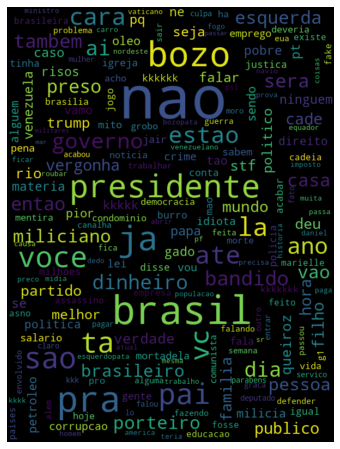

In [21]:
from wordcloud import WordCloud

%matplotlib inline

word_cloud = WordCloud(height=800, width=600, max_font_size=110,
                      collocations=False).generate(todas_palavras)

plt.figure(figsize=(10,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Começa o treino da ML

#### Vai estar separado o treino em base original (em minusculo), base com preprocessamento sem limpeza com unidecode, base com preprocessamento com limpeza de unidecode

In [22]:
### Criar o bagofwords
# base original sem nada
vectorizer = CountVectorizer(analyzer='word', lowercase=False)
bow = vectorizer.fit_transform(comentarios_df['comentario'])

# bow base original
vectorizer_lower = CountVectorizer(analyzer='word', lowercase=False)
bow_lower = vectorizer_lower.fit_transform(comentarios_df['minusculo'])

# bow base original minusculo removendo whitespace
vectorizer_spacelower = CountVectorizer(analyzer='word', lowercase=False)
bow_spacelower = vectorizer_spacelower.fit_transform(comentarios_df['whitespacesnone'])

# bow preprocessamento sem unidecode
vectorizer_su = CountVectorizer(analyzer='word', lowercase=False)
bow_su = vectorizer_su.fit_transform(comentarios_df['comentario_final_su'])

# bow preprocessamento com unidecode
vectorizer_wu = CountVectorizer(analyzer='word', lowercase=False)
bow_wu = vectorizer_wu.fit_transform(comentarios_df['comentario_final_wu'])

In [23]:
### Gerar treino e classe com o train_test_split

# treino e classe base original
treino, teste, classe_treino, classe_teste = train_test_split(bow,
       comentarios_df['toxico'], random_state=42)

# treino e classe base original com letras minusculas 
treino_lower, teste_lower, classe_treino_lower, classe_teste_lower = train_test_split(bow_lower,
       comentarios_df['toxico'], random_state=42)

# treino e classe base com preprocessamento sem unidecode
treino_su, teste_su, classe_treino_su, classe_teste_su = train_test_split(bow_su,
       comentarios_df['toxico'], random_state=42)

# treino e classe base com preprocessamento com unidecode
treino_wu, teste_wu, classe_treino_wu, classe_teste_wu = train_test_split(bow_wu,
       comentarios_df['toxico'], random_state=42)

### Criação dos modelos e treinamento

##### Para cada tipo de modelo foi criado um heatmap de suas matrizes de confusão, gerado precisao e acuracia

### ------------------------------ REGRESSÃO LOGÍSTICA ------------------------------

##### PROCESSO COM REGRESSÃO LOGÍSTICA

In [24]:
# Base original
classificador = LogisticRegression(solver='lbfgs')
classificador.fit(treino, classe_treino)

previsao = classificador.predict(teste)

acuracia = accuracy_score(classe_teste, previsao)
precisao = precision_score(classe_teste, previsao)

print("Acuracia: %.2f%%" % (acuracia * 100.0), "Precisao: %.2f%%" % (precisao * 100.0))

#report = classification_report(previsao, classe_teste)

#print('report:', report, sep='\n')

Acuracia: 56.43% Precisao: 61.34%


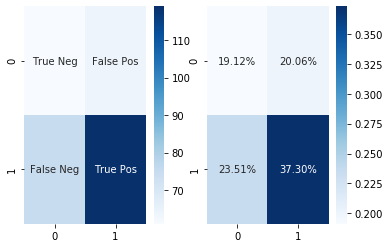

In [25]:
results_classificador = confusion_matrix(previsao, classe_teste) 

labels_classificador = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador = np.asarray(labels_classificador).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador, annot=labels_classificador, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador/np.sum(results_classificador), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [26]:
# Base original com letras minusculas 
classificador_lower = LogisticRegression(solver='lbfgs')
classificador_lower.fit(treino_lower, classe_treino_lower)

previsao_lower = classificador_lower.predict(teste_lower)

acuracia_lower = accuracy_score(classe_teste_lower, previsao_lower)
precisao_lower = precision_score(classe_teste_lower, previsao_lower)

print("Acuracia: %.2f%%" % (acuracia_lower * 100.0), "Precisao: %.2f%%" % (precisao_lower * 100.0))

Acuracia: 54.86% Precisao: 60.43%


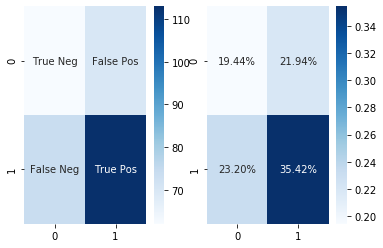

In [27]:
results_classificador_lower = confusion_matrix(previsao_lower, classe_teste_lower) 

labels_classificador_lower = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador_lower = np.asarray(labels_classificador_lower).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador_lower, annot=labels_classificador_lower, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador_lower/np.sum(results_classificador_lower), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [28]:
# Base com preprocessamento sem unidecode
classificador_su = LogisticRegression(solver='lbfgs')
classificador_su.fit(treino_su, classe_treino_su)

previsao_su = classificador_su.predict(teste_su)

acuracia_su = accuracy_score(classe_teste_su, previsao_su)
precisao_su = precision_score(classe_teste_su, previsao_su)

print("Acuracia: %.2f%%" % (acuracia_su * 100.0), "Precisao: %.2f%%" % (precisao_su * 100.0))

Acuracia: 52.98% Precisao: 57.89%


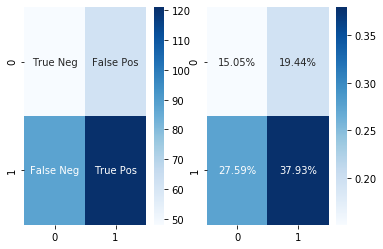

In [29]:
results_classificador_su = confusion_matrix(previsao_su, classe_teste_su) 

labels_classificador_su = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador_su = np.asarray(labels_classificador_su).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador_su, annot=labels_classificador_su, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador_su/np.sum(results_classificador_su), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [30]:
# Base com preprocessamento com unidecode
classificador_wu = LogisticRegression(solver='lbfgs')
classificador_wu.fit(treino_wu, classe_treino_wu)

previsao_wu = classificador_wu.predict(teste_wu)

acuracia_wu = accuracy_score(classe_teste_wu, previsao_wu)
precisao_wu = precision_score(classe_teste_wu, previsao_wu)

print("Acuracia: %.2f%%" % (acuracia_wu * 100.0), "Precisao: %.2f%%" % (precisao_wu * 100.0))

Acuracia: 53.61% Precisao: 58.62%


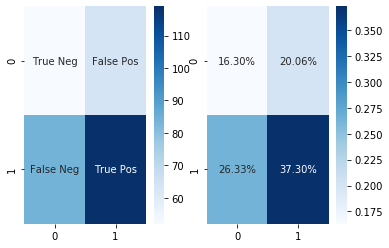

In [31]:
results_classificador_wu = confusion_matrix(previsao_wu, classe_teste_wu) 

labels_classificador_wu = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador_wu = np.asarray(labels_classificador_wu).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador_wu, annot=labels_classificador_wu, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador_wu/np.sum(results_classificador_wu), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

### ------------------------------ XGBOOST ------------------------------

##### PROCESSO COM XGBOOST

In [34]:
# Base original 
model = XGBClassifier()
model.fit(treino, classe_treino)

y_pred = model.predict(teste)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(classe_teste, predictions)
precision = precision_score(classe_teste, predictions)

print("Acuracia: %.2f%%" % (accuracy * 100.0), "Precisao: %.2f%%" % (precision * 100.0))

Acuracia: 54.86% Precisao: 59.07%


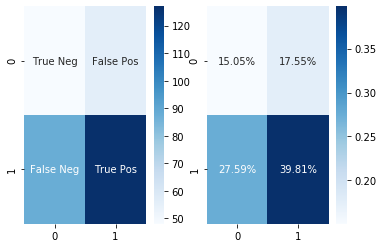

In [35]:
results_model = confusion_matrix(y_pred, classe_teste) 

labels_model = ["True Neg","False Pos","False Neg","True Pos"]
labels_model = np.asarray(labels_model).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_model, annot=labels_model, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_model/np.sum(results_model), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [36]:
# Base original com letras minusculas 
model_lower = XGBClassifier()
model_lower.fit(treino_lower, classe_treino_lower)

y_pred_lower = model_lower.predict(teste_lower)
predictions_lower = [round(value) for value in y_pred_lower]

accuracy_lower = accuracy_score(classe_teste_lower, predictions_lower)
precision_lower = precision_score(classe_teste_lower, predictions_lower)

print("Acuracia: %.2f%%" % (accuracy_lower * 100.0), "Precisao: %.2f%%" % (precision_lower * 100.0))

Acuracia: 53.61% Precisao: 58.45%


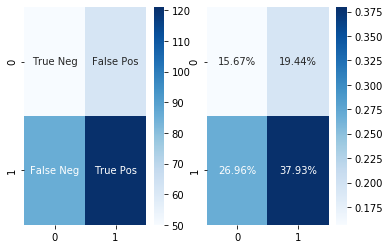

In [37]:
results_model_lower = confusion_matrix(y_pred_lower, classe_teste_lower) 

labels_model_lower = ["True Neg","False Pos","False Neg","True Pos"]
labels_model_lower = np.asarray(labels_model_lower).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_model_lower, annot=labels_model_lower, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_model_lower/np.sum(results_model_lower), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [38]:
# Base com preprocessamento sem unidecode

model_su = XGBClassifier()
model_su.fit(treino_su, classe_treino_su)

y_pred_su = model_su.predict(teste_su)
predictions_su = [round(value) for value in y_pred_su]

accuracy_su = accuracy_score(classe_teste_su, predictions_su)
precision_su = precision_score(classe_teste_su, predictions_su)

print("Acuracia: %.2f%%" % (accuracy_su * 100.0), "Precisao: %.2f%%" % (precision_su * 100.0))

Acuracia: 52.35% Precisao: 57.08%


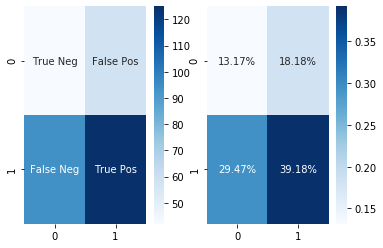

In [39]:
results_model_su = confusion_matrix(y_pred_su, classe_teste_su) 

labels_model_su = ["True Neg","False Pos","False Neg","True Pos"]
labels_model_su = np.asarray(labels_model_su).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_model_su, annot=labels_model_su, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_model_su/np.sum(results_model_su), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [40]:
# Base com preprocessamento com unidecode
model_wu = XGBClassifier()
model_wu.fit(treino_wu, classe_treino_wu)

y_pred_wu = model_wu.predict(teste_wu)
predictions_wu = [round(value) for value in y_pred_wu]

accuracy_wu = accuracy_score(classe_teste_wu, predictions_wu)
precision_wu = precision_score(classe_teste_wu, predictions_wu)

print("Acuracia: %.2f%%" % (accuracy_su * 100.0), "Precisao: %.2f%%" % (precision_wu * 100.0))

Acuracia: 52.35% Precisao: 58.45%


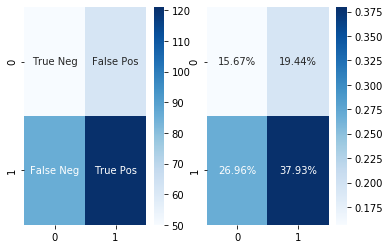

In [41]:
results_model_wu = confusion_matrix(y_pred_wu, classe_teste_wu) 

labels_model_wu = ["True Neg","False Pos","False Neg","True Pos"]
labels_model_wu = np.asarray(labels_model_wu).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_model_wu, annot=labels_model_wu, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_model_wu/np.sum(results_model_wu), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

### ------------------------------ GRADIENT BOOSTING CLASSIFIER ------------------------------

##### PROCESSO COM GRADIENT BOOSTING CLASSIFIER

In [42]:
# Define possibilidades de valores de aprendizado e identifica qual tras o melhor scrore em acuracia para cada coluna
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

In [43]:
# Coluna base original
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate, random_state=42)
    gb.fit(treino, classe_treino)
    print("Coluna base original ------")
    print()
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(treino, classe_treino)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(teste, classe_teste)))
    print()

Coluna base original ------

Learning rate:  0.05
Accuracy score (training): 0.711
Accuracy score (validation): 0.577

Coluna base original ------

Learning rate:  0.1
Accuracy score (training): 0.773
Accuracy score (validation): 0.580

Coluna base original ------

Learning rate:  0.25
Accuracy score (training): 0.862
Accuracy score (validation): 0.589

Coluna base original ------

Learning rate:  0.5
Accuracy score (training): 0.942
Accuracy score (validation): 0.555

Coluna base original ------

Learning rate:  0.75
Accuracy score (training): 0.973
Accuracy score (validation): 0.592

Coluna base original ------

Learning rate:  1
Accuracy score (training): 0.978
Accuracy score (validation): 0.577



In [44]:
# Coluna minusculo
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate, random_state=42)
    gb.fit(treino_lower, classe_treino_lower)
    print("Coluna minusculo ------")
    print()
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(treino_lower, classe_treino_lower)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(teste_lower, classe_teste_lower)))
    print()

Coluna minusculo ------

Learning rate:  0.05
Accuracy score (training): 0.719
Accuracy score (validation): 0.599

Coluna minusculo ------

Learning rate:  0.1
Accuracy score (training): 0.786
Accuracy score (validation): 0.567

Coluna minusculo ------

Learning rate:  0.25
Accuracy score (training): 0.857
Accuracy score (validation): 0.567

Coluna minusculo ------

Learning rate:  0.5
Accuracy score (training): 0.941
Accuracy score (validation): 0.574

Coluna minusculo ------

Learning rate:  0.75
Accuracy score (training): 0.960
Accuracy score (validation): 0.552

Coluna minusculo ------

Learning rate:  1
Accuracy score (training): 0.973
Accuracy score (validation): 0.574



In [46]:
# Coluna preprocessamento sem unidecode
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate, random_state=42)
    gb.fit(treino_su, classe_treino_su)
    print("Coluna preprocessamento sem unidecode ------")
    print()
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(treino_su, classe_treino_su)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(teste_su, classe_teste_su)))
    print()

Coluna preprocessamento sem unidecode ------

Learning rate:  0.05
Accuracy score (training): 0.690
Accuracy score (validation): 0.592

Coluna preprocessamento sem unidecode ------

Learning rate:  0.1
Accuracy score (training): 0.791
Accuracy score (validation): 0.571

Coluna preprocessamento sem unidecode ------

Learning rate:  0.25
Accuracy score (training): 0.846
Accuracy score (validation): 0.583

Coluna preprocessamento sem unidecode ------

Learning rate:  0.5
Accuracy score (training): 0.952
Accuracy score (validation): 0.608

Coluna preprocessamento sem unidecode ------

Learning rate:  0.75
Accuracy score (training): 0.965
Accuracy score (validation): 0.577

Coluna preprocessamento sem unidecode ------

Learning rate:  1
Accuracy score (training): 0.968
Accuracy score (validation): 0.574



In [48]:
# Coluna preprocessamento com unidecode
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate, random_state=42)
    gb.fit(treino_wu, classe_treino_wu)
    print("Coluna preprocessamento com unidecode ------")
    print()
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(treino_wu, classe_treino_wu)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(teste_wu, classe_teste_wu)))
    print()

Coluna preprocessamento com unidecode ------

Learning rate:  0.05
Accuracy score (training): 0.696
Accuracy score (validation): 0.592

Coluna preprocessamento com unidecode ------

Learning rate:  0.1
Accuracy score (training): 0.779
Accuracy score (validation): 0.561

Coluna preprocessamento com unidecode ------

Learning rate:  0.25
Accuracy score (training): 0.851
Accuracy score (validation): 0.589

Coluna preprocessamento com unidecode ------

Learning rate:  0.5
Accuracy score (training): 0.930
Accuracy score (validation): 0.614

Coluna preprocessamento com unidecode ------

Learning rate:  0.75
Accuracy score (training): 0.928
Accuracy score (validation): 0.589

Coluna preprocessamento com unidecode ------

Learning rate:  1
Accuracy score (training): 0.970
Accuracy score (validation): 0.580



In [49]:
# Base original 
gb = GradientBoostingClassifier(learning_rate = 0.75, random_state = 42)
gb.fit(treino, classe_treino)
predictions = gb.predict(teste)

accuracy0 = accuracy_score(classe_teste, predictions)
precision0 = precision_score(classe_teste, predictions)
print("Acuracia: %.2f%%" % (accuracy0 * 100.0), "Precisao: %.2f%%" % (precision0 * 100.0))

Acuracia: 59.25% Precisao: 61.57%


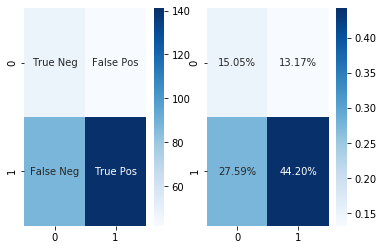

In [50]:
results_gb = confusion_matrix(predictions, classe_teste) 

labels_gb = ["True Neg","False Pos","False Neg","True Pos"]
labels_gb = np.asarray(labels_gb).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_gb, annot=labels_gb, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_gb/np.sum(results_gb), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [52]:
# Base original com letras minusculas 
gb_lower = GradientBoostingClassifier(learning_rate = 0.5, random_state = 42)
gb_lower.fit(treino_lower, classe_treino_lower)
predictions_lower = gb.predict(teste_lower)

accuracy1 = accuracy_score(classe_teste_lower, predictions_lower)
precision1 = precision_score(classe_teste_lower, predictions_lower)
print("Acuracia: %.2f%%" % (accuracy1 * 100.0), "Precisao: %.2f%%" % (precision1 * 100.0))

ValueError: Number of features of the model must match the input. Model n_features is 6855 and input n_features is 5736 

In [ ]:
results_gb_lower = confusion_matrix(predictions_lower, classe_teste_lower) 

labels_gb_lower = ["True Neg","False Pos","False Neg","True Pos"]
labels_gb_lower = np.asarray(labels_gb_lower).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_gb_lower, annot=labels_gb_lower, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_gb_lower/np.sum(results_gb_lower), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [53]:
# Base com preprocessamento sem unidecode
gb_su = GradientBoostingClassifier(learning_rate = 0.5, random_state = 42)
gb_su.fit(treino_su, classe_treino_su)
predictions_su = gb_su.predict(teste_su)

accuracy2 = accuracy_score(classe_teste_su, predictions_su)
precision2 = precision_score(classe_teste_su, predictions_su)
print("Acuracia: %.2f%%" % (accuracy2 * 100.0), "Precisao: %.2f%%" % (precision2 * 100.0))

Acuracia: 60.82% Precisao: 62.61%


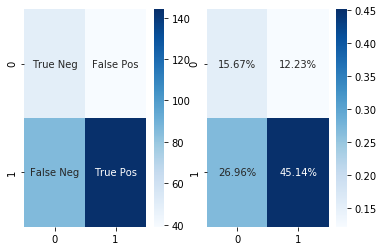

In [54]:
results_gb_su = confusion_matrix(predictions_su, classe_teste_su) 

labels_gb_su = ["True Neg","False Pos","False Neg","True Pos"]
labels_gb_su = np.asarray(labels_gb_su).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_gb_su, annot=labels_gb_su, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_gb_su/np.sum(results_gb_su), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [55]:
# Base com preprocessamento com unidecode
gb_wu = GradientBoostingClassifier(learning_rate = 0.5, random_state = 42)
gb_wu.fit(treino_wu, classe_treino_wu)
predictions_wu = gb_wu.predict(teste_wu)

accuracy3 = accuracy_score(classe_teste_wu, predictions_wu)
precision3 = precision_score(classe_teste_wu, predictions_wu)
print("Acuracia: %.2f%%" % (accuracy3 * 100.0), "Precisao: %.2f%%" % (precision3 * 100.0))

Acuracia: 61.44% Precisao: 63.04%


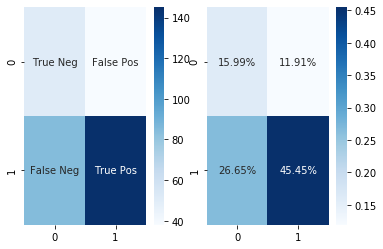

In [56]:
results_gb_wu = confusion_matrix(predictions_wu, classe_teste_wu) 

labels_gb_wu = ["True Neg","False Pos","False Neg","True Pos"]
labels_gb_wu = np.asarray(labels_gb_wu).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_gb_wu, annot=labels_gb_wu, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_gb_wu/np.sum(results_gb_wu), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

## Salva os modelos com pickle

In [ ]:
joblib.dump(classificador_lower, 'lr_classificador_lower.pkl')
joblib.dump(vectorizer_lower, 'cv_lower.pkl')
print("Modelo regressao logistica lower")
#lr_lower = joblib.load('lr_classificador_lower.pkl')

In [ ]:
model_loaded = open('lr_classificador_lower.pkl', 'rb')
cv_loaded = open('cv_lower.pkl', 'rb')
clf = joblib.load(model_loaded)
cvteste = joblib.load(cv_loaded)

datateste = ['sera possivel que sempre vai dar 1 acho que ta viciado']
vectteste = cvteste.transform(datateste).toarray()
predictteste = clf.predict(vectteste)

print(predictteste)

In [ ]:
joblib.dump(classificador_wu, 'lr_classificador_wu.pkl')
joblib.dump(vectorizer_wu, 'cv_wu.pkl')
print("Modelo regressao logistica wu")
#lr_lower = joblib.load('lr_classificador_lower.pkl')

In [ ]:
model_loaded2 = open('lr_classificador_wu.pkl', 'rb')
cv_loaded2 = open('cv_wu.pkl', 'rb')
clf2 = joblib.load(model_loaded2)
cvteste2 = joblib.load(cv_loaded2)

datateste2 = ['sera possivel que sempre vai dar 1 acho que ta viciado']

#doc2 = nlp(datateste2)
#c2 = ' '.join([token.text for token in doc2 if token.text not in pontuacoes and token.text not in stop_word and not token.text.isdigit()])
    
vectteste2 = cvteste2.transform(datateste2).toarray()
predictteste2 = clf2.predict(vectteste2)

print(predictteste2)

In [ ]:
joblib.dump(classificador_su, 'lr_classificador_su.pkl')
joblib.dump(vectorizer_su, 'cv_su.pkl')
print("Modelo regressao logistica su")
#lr_lower = joblib.load('lr_classificador_lower.pkl')

In [ ]:
model_loaded3 = open('lr_classificador_su.pkl', 'rb')
cv_loaded3 = open('cv_su.pkl', 'rb')
clf3 = joblib.load(model_loaded3)
cvteste3 = joblib.load(cv_loaded3)

datateste3 = ['sera possivel que sempre vai dar 1 acho que ta viciado']
vectteste3 = cvteste3.transform(datateste3).toarray()
predictteste3 = clf3.predict(vectteste3)

print(predictteste3)